In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from catboost import CatBoostRegressor
from tqdm import tqdm
import gc
import datetime as dt

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
properties2016 = pd.read_csv('zillow/properties_2016.csv')
'''properties2017 = pd.read_csv('zillow/properties_2017.csv',error_bad_lines=False)'''

train2016 = pd.read_csv('zillow/train_2016_v2.csv', parse_dates=['transactiondate'])
train2017 = pd.read_csv('zillow/train_2017.csv', parse_dates=['transactiondate'])

def add_date_features(df):
    df["transaction_year"] = df["transactiondate"].dt.year
    df["transaction_month"] = (df["transactiondate"].dt.year - 2016)*12 + df["transactiondate"].dt.month
    df["transaction_day"] = df["transactiondate"].dt.day
    df["transaction_quarter"] = (df["transactiondate"].dt.year - 2016)*4 +df["transactiondate"].dt.quarter
    df.drop(["transactiondate"], inplace=True, axis=1)
    return df

train2016 = add_date_features(train2016)
'''train2017 = add_date_features(train2017)'''

sample_submission = pd.read_csv('zillow/sample_submission.csv')

train2016 = pd.merge(train2016, properties2016, how = 'left', on = 'parcelid')
'''train2017 = pd.merge(train2017, properties2017, how = 'left', on = 'parcelid')'''


train_df = pd.concat([train2016, train2017], axis = 0)
test_df = pd.merge(sample_submission[['ParcelId']], properties2016.rename(columns = {'parcelid': 'ParcelId'}), how = 'left', on = 'ParcelId')

del properties2016, train2016
gc.collect();


/home/kai/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)
train_df['logerror'].ix[train_df['logerror']>ulimit] = ulimit
train_df['logerror'].ix[train_df['logerror']<llimit] = llimit

/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [4]:
train_df = train_df[[c for c in train_df if train_df[c].isnull().sum() < train_df.shape[0]/2]]

mean_values = train_df.median(axis=0)
train_df = train_df.fillna(mean_values, inplace=True)

mean_values = test_df.median(axis=0)
test_df = test_df.fillna(mean_values, inplace=True)

In [5]:
dfs = [train_df, test_df]

for d in dfs:
    d['taxdiff'] = d['taxvaluedollarcnt'] - d['taxamount']
    d['taxdiff2'] = d['structuretaxvaluedollarcnt'] - d['landtaxvaluedollarcnt']
    d['bathdiff'] = d['fullbathcnt'] - d['bathroomcnt']
    d['bathdiff2'] = d['calculatedbathnbr'] - d['bathroomcnt']
    d['finisheddiff'] = d['calculatedfinishedsquarefeet'] - d['finishedsquarefeet12']

In [6]:
from sklearn.preprocessing import LabelEncoder

fe_encode = ['fips', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidzip']
encoder = LabelEncoder()
for fe in fe_encode:
    train_df[fe] = pd.DataFrame(encoder.fit_transform(train_df[fe].values))
    test_df[fe] = pd.DataFrame(encoder.fit_transform(test_df[fe].values))

In [7]:
from sklearn.cross_validation import train_test_split

y = train_df['logerror']

X_train, X_cv, y_train, y_cv = train_test_split(train_df.drop('logerror', axis=1), y, test_size=0.2, random_state=33)

X_train.shape, X_cv.shape, y_train.shape, y_cv.shape

/home/kai/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


((134310, 33), (33578, 33), (134310,), (33578,))

In [8]:
test_df['transactiondate'] = pd.Timestamp('2016-12-01') 
test_df = add_date_features(test_df)

X_test = test_df

In [9]:
droplist = []
for fe in X_train:
    if X_train[fe].dtype == 'object':
        droplist.append(fe)

X_train = X_train.drop(droplist, axis=1)

In [10]:
X_train.head()

,assessmentyear,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,censustractandblock,finishedsquarefeet12,fips,fullbathcnt,landtaxvaluedollarcnt,latitude,longitude,parcelid,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,structuretaxvaluedollarcnt,taxamount,taxvaluedollarcnt,transaction_day,transaction_month,transaction_quarter,transaction_year,yearbuilt,taxdiff,taxdiff2,bathdiff,bathdiff2,finisheddiff
48161,2015.0,0.0,0.0,2.0,1360.0,6.111003e+13,1360.0,2,2.0,9766.0,34201917.0,-119198122.0,17147912,2,6.111003e+07,23,1,364,0.0,48990.0,659.66,58756.0,22.0,6.0,2.0,2016.0,1957.0,58096.34,39224.0,2.0,2.0,0.0
25752,2015.0,2.0,3.0,2.0,1540.0,6.037615e+13,1518.0,1,2.0,192970.0,34021500.0,-118173431.0,12440381,10,6.037620e+07,61,0,312,0.0,132000.0,4542.75,342872.0,16.0,6.0,2.0,2016.0,1970.0,338329.25,-60970.0,0.0,0.0,22.0
14744,2015.0,5.0,7.0,5.0,3332.0,6.037604e+13,1518.0,0,5.0,283191.0,33879145.0,-118359355.0,11442944,2,6.037604e+07,125,2,82,0.0,278103.0,7262.54,561294.0,8.0,3.0,1.0,2016.0,1980.0,554031.46,-5088.0,0.0,0.0,1814.0
61824,2015.0,2.0,3.0,2.0,1540.0,6.037615e+13,1518.0,0,2.0,192970.0,34021500.0,-118173431.0,12039617,10,6.037620e+07,19,2,200,0.0,132000.0,4542.75,342872.0,16.0,6.0,2.0,2016.0,1970.0,338329.25,-60970.0,0.0,0.0,22.0
6927,2015.0,1.0,2.0,1.0,936.0,6.037241e+13,936.0,0,1.0,71721.0,33951630.0,-118274830.0,12221119,6,6.037241e+07,19,2,2,0.0,30738.0,1569.75,102459.0,2.0,2.0,1.0,2016.0,1924.0,100889.25,-40983.0,0.0,0.0,0.0


In [11]:
'''for fe in X_train:
    boo = False
    for fe2 in X_train:
        if boo:
            X_train['{}*{}'.format(fe, fe2)] = X_train[str(fe)]*X_train[str(fe2)]
        if fe == fe2:
            boo = True
    boo = False'''

for fe in X_train:
    num_uniques = len(X_train[fe].unique())
    print('{}: {}'.format(fe, num_uniques))

assessmentyear: 1
bathroomcnt: 23
bedroomcnt: 16
calculatedbathnbr: 22
calculatedfinishedsquarefeet: 4854
censustractandblock: 37268
finishedsquarefeet12: 4729
fips: 3
fullbathcnt: 14
landtaxvaluedollarcnt: 47486
latitude: 59733
longitude: 58166
parcelid: 132575
propertylandusetypeid: 14
rawcensustractandblock: 37493
regionidcity: 177
regionidcounty: 3
regionidzip: 387
roomcnt: 16
structuretaxvaluedollarcnt: 46417
taxamount: 68738
taxvaluedollarcnt: 46526
transaction_day: 31
transaction_month: 12
transaction_quarter: 4
transaction_year: 1
yearbuilt: 129
taxdiff: 71577
taxdiff2: 55619
bathdiff: 8
bathdiff2: 6
finisheddiff: 1864


In [12]:
X_train.head()

,assessmentyear,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,censustractandblock,finishedsquarefeet12,fips,fullbathcnt,landtaxvaluedollarcnt,latitude,longitude,parcelid,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,structuretaxvaluedollarcnt,taxamount,taxvaluedollarcnt,transaction_day,transaction_month,transaction_quarter,transaction_year,yearbuilt,taxdiff,taxdiff2,bathdiff,bathdiff2,finisheddiff
48161,2015.0,0.0,0.0,2.0,1360.0,6.111003e+13,1360.0,2,2.0,9766.0,34201917.0,-119198122.0,17147912,2,6.111003e+07,23,1,364,0.0,48990.0,659.66,58756.0,22.0,6.0,2.0,2016.0,1957.0,58096.34,39224.0,2.0,2.0,0.0
25752,2015.0,2.0,3.0,2.0,1540.0,6.037615e+13,1518.0,1,2.0,192970.0,34021500.0,-118173431.0,12440381,10,6.037620e+07,61,0,312,0.0,132000.0,4542.75,342872.0,16.0,6.0,2.0,2016.0,1970.0,338329.25,-60970.0,0.0,0.0,22.0
14744,2015.0,5.0,7.0,5.0,3332.0,6.037604e+13,1518.0,0,5.0,283191.0,33879145.0,-118359355.0,11442944,2,6.037604e+07,125,2,82,0.0,278103.0,7262.54,561294.0,8.0,3.0,1.0,2016.0,1980.0,554031.46,-5088.0,0.0,0.0,1814.0
61824,2015.0,2.0,3.0,2.0,1540.0,6.037615e+13,1518.0,0,2.0,192970.0,34021500.0,-118173431.0,12039617,10,6.037620e+07,19,2,200,0.0,132000.0,4542.75,342872.0,16.0,6.0,2.0,2016.0,1970.0,338329.25,-60970.0,0.0,0.0,22.0
6927,2015.0,1.0,2.0,1.0,936.0,6.037241e+13,936.0,0,1.0,71721.0,33951630.0,-118274830.0,12221119,6,6.037241e+07,19,2,2,0.0,30738.0,1569.75,102459.0,2.0,2.0,1.0,2016.0,1924.0,100889.25,-40983.0,0.0,0.0,0.0


In [13]:
'''plt.figure(figsize=(12,12))
sns.jointplot(x=X_train.taxdiff.values, y=y_train, size=10)
plt.show()'''

'plt.figure(figsize=(12,12))\nsns.jointplot(x=X_train.taxdiff.values, y=y_train, size=10)\nplt.show()'

In [10]:
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

        
train_y = y_train
train_X = X_train.drop(["parcelid"], axis=1)
y_mean = np.mean(y_train)


xgb_params = {
    'nthread' : 8,
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'base_score': y_mean,
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=100)

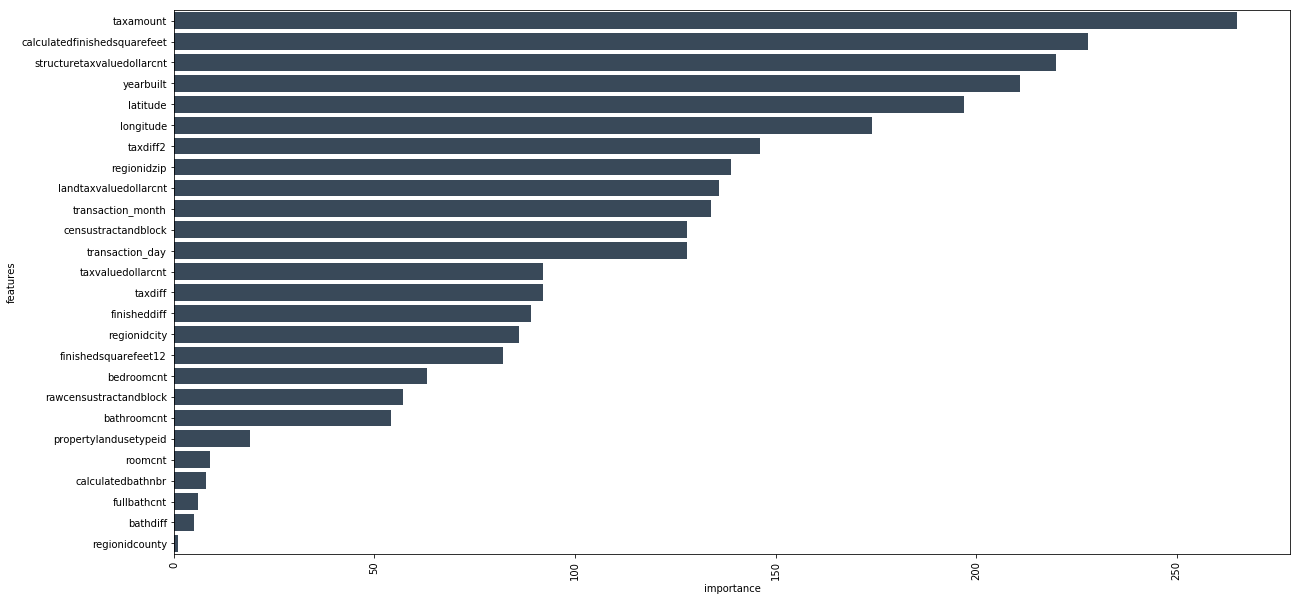

In [11]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sns.barplot(data=features,x="importance",y="features",ax=ax,orient="h",color="#34495e")

In [12]:
features = pd.DataFrame(features['features'].head(int(.9*features['features'].__len__())))
features.reset_index()

,index,features
0,0,taxamount
1,10,calculatedfinishedsquarefeet
2,9,structuretaxvaluedollarcnt
3,1,yearbuilt
4,8,latitude
5,3,longitude
6,14,taxdiff2
7,13,regionidzip
8,15,landtaxvaluedollarcnt
9,4,transaction_month


,taxamount,calculatedfinishedsquarefeet,structuretaxvaluedollarcnt,yearbuilt,latitude,longitude,taxdiff2,regionidzip,landtaxvaluedollarcnt,transaction_month,censustractandblock,transaction_day,taxvaluedollarcnt,taxdiff,finisheddiff,regionidcity,finishedsquarefeet12,bedroomcnt,rawcensustractandblock,bathroomcnt,propertylandusetypeid,roomcnt,calculatedbathnbr,ParcelId
79166,3223.98,3182.0,155226.0,1966.0,34111521.0,-118303849.0,65286.0,25,89940.0,9.0,6.037189e+13,23.0,245166.0,241942.02,0.0,19,3182.0,5.0,6.037189e+07,4.0,6,0.0,4.0,12034935
69155,1377.36,1740.0,61043.0,1971.0,33872772.0,-117784276.0,35768.0,353,25275.0,8.0,6.059022e+13,24.0,86318.0,84940.64,0.0,48,1740.0,4.0,6.059022e+07,2.0,6,7.0,2.0,14192659
45505,4542.75,1540.0,132000.0,1970.0,34021500.0,-118173431.0,-60970.0,214,192970.0,6.0,6.037615e+13,16.0,342872.0,338329.25,22.0,95,1518.0,3.0,6.037620e+07,2.0,6,0.0,2.0,11194915
43666,4542.75,1540.0,132000.0,1970.0,34021500.0,-118173431.0,-60970.0,122,192970.0,6.0,6.037615e+13,16.0,342872.0,338329.25,22.0,43,1518.0,3.0,6.037620e+07,2.0,10,0.0,2.0,14380461
12129,8835.56,2521.0,301634.0,1965.0,34237743.0,-119087637.0,-213455.0,358,515089.0,2.0,6.111005e+13,26.0,816723.0,807887.44,0.0,137,2521.0,5.0,6.111005e+07,2.0,6,8.0,2.0,17124512


In [17]:
# Now let us look at the correlation coefficient of each of these variables #
'''x_cols = [col for col in train_df.columns if col not in ['logerror'] if train_df[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df[col].values, train_df.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
corr_df'''

"x_cols = [col for col in train_df.columns if col not in ['logerror'] if train_df[col].dtype=='float64']\n\nlabels = []\nvalues = []\nfor col in x_cols:\n    labels.append(col)\n    values.append(np.corrcoef(train_df[col].values, train_df.logerror.values)[0,1])\ncorr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})\ncorr_df = corr_df.sort_values(by='corr_values')\ncorr_df"

In [18]:
'''corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.01) | (corr_df['corr_values'] < -0.01)]'''

"corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.01) | (corr_df['corr_values'] < -0.01)]"

In [19]:
'''corr_df_ = pd.DataFrame()
for name in corr_df_sel['col_labels']:
    corr_df_[name] = train_df[name]

corr_df_.head()'''

"corr_df_ = pd.DataFrame()\nfor name in corr_df_sel['col_labels']:\n    corr_df_[name] = train_df[name]\n\ncorr_df_.head()"

In [20]:
'''from statsmodels.stats.outliers_influence import variance_inflation_factor  
import warnings
warnings.filterwarnings("ignore")

def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif

vifDict = calculate_vif_(corr_df_)

vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'],ascending=False,inplace=True)
validVariables = vifDf[vifDf["vifScore"]<=5]
variablesWithMC  = vifDf[vifDf["vifScore"]>5]

validVariables, variablesWithMC'''

'from statsmodels.stats.outliers_influence import variance_inflation_factor  \nimport warnings\nwarnings.filterwarnings("ignore")\n\ndef calculate_vif_(X):\n    variables = list(X.columns)\n    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}\n    return vif\n\nvifDict = calculate_vif_(corr_df_)\n\nvifDf = pd.DataFrame()\nvifDf[\'variables\'] = vifDict.keys()\nvifDf[\'vifScore\'] = vifDict.values()\nvifDf.sort_values(by=[\'vifScore\'],ascending=False,inplace=True)\nvalidVariables = vifDf[vifDf["vifScore"]<=5]\nvariablesWithMC  = vifDf[vifDf["vifScore"]>5]\n\nvalidVariables, variablesWithMC'

In [21]:
'''valid_df = pd.DataFrame()

for name in validVariables['variables']:
    valid_df[name] = train_df[name]

valid_df.head()'''

"valid_df = pd.DataFrame()\n\nfor name in validVariables['variables']:\n    valid_df[name] = train_df[name]\n\nvalid_df.head()"

In [22]:
'''fe1 = []
for f in valid_df:
    fe1.append(f)
    
fe1.append('parcelid')
fe1.append('transaction_year')
fe1.append('transaction_month')
fe1.append('transaction_day')
fe1.append('transaction_quarter')

fe1'''

"fe1 = []\nfor f in valid_df:\n    fe1.append(f)\n    \nfe1.append('parcelid')\nfe1.append('transaction_year')\nfe1.append('transaction_month')\nfe1.append('transaction_day')\nfe1.append('transaction_quarter')\n\nfe1"

In [13]:
features_test = np.append(features['features'].values,'ParcelId')

X_train = X_train.rename(columns = {'parcelid': 'ParcelId'})
X_cv = X_cv.rename(columns = {'parcelid': 'ParcelId'})

X_train = X_train[features_test]
X_cv = X_cv[features_test]

X_test = test_df[features_test]

X_test.head()

,taxamount,calculatedfinishedsquarefeet,structuretaxvaluedollarcnt,yearbuilt,latitude,longitude,taxdiff2,regionidzip,landtaxvaluedollarcnt,transaction_month,censustractandblock,transaction_day,taxvaluedollarcnt,taxdiff,finisheddiff,regionidcity,finishedsquarefeet12,bedroomcnt,rawcensustractandblock,bathroomcnt,propertylandusetypeid,roomcnt,calculatedbathnbr,ParcelId
0,3991.78,1572.0,122590.0,1963.0,34144442.0,-118654084.0,122581.0,194,9.0,12,6.037572e+13,1,9.0,-3982.78,33.0,107,1539.0,0.0,6.037800e+07,0.0,12,0.0,2.0,10754147
1,3991.78,1572.0,122590.0,1963.0,34140430.0,-118625364.0,95074.0,194,27516.0,12,6.037572e+13,1,27516.0,23524.22,33.0,107,1539.0,0.0,6.037800e+07,0.0,6,0.0,2.0,10759547
2,20800.37,73026.0,650756.0,1963.0,33989359.0,-118394633.0,-111875.0,72,762631.0,12,6.037572e+13,1,1413387.0,1392586.63,71487.0,147,1539.0,0.0,6.037703e+07,0.0,1,0.0,2.0,10843547
3,14557.57,5068.0,571346.0,1948.0,34148863.0,-118437206.0,-14142.0,235,585488.0,12,6.037572e+13,1,1156834.0,1142276.43,3529.0,20,1539.0,0.0,6.037141e+07,0.0,1,0.0,2.0,10859147
4,5725.17,1776.0,193796.0,1947.0,34194168.0,-118385816.0,-45899.0,245,239695.0,12,6.037572e+13,1,433491.0,427765.83,237.0,20,1539.0,0.0,6.037123e+07,0.0,0,0.0,2.0,10879947


In [16]:
test_date = ['2016-10-01','2016-11-01','2016-12-01','2017-10-01','2017-11-01','2017-12-01']

test_columns = ['201610','201611','201612','201710','201711','201712']

from datetime import datetime

test_dates = []
for d in test_date:
    test_dates.append(datetime.strptime(d, '%Y-%m-%d'))
test_dates

[datetime.datetime(2016, 10, 1, 0, 0),
 datetime.datetime(2016, 11, 1, 0, 0),
 datetime.datetime(2016, 12, 1, 0, 0),
 datetime.datetime(2017, 10, 1, 0, 0),
 datetime.datetime(2017, 11, 1, 0, 0),
 datetime.datetime(2017, 12, 1, 0, 0)]

In [17]:
X_train = X_train.drop('ParcelId', axis=1)
X_train.shape, X_cv.shape

ValueError: labels ['ParcelId'] not contained in axis

In [18]:
import lightgbm as lgb


d_train = lgb.Dataset(X_train, label=y_train)



##### RUN LIGHTGBM

params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.0021 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.5      # feature_fraction -- OK, back to .5, but maybe later increase this
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0

clf = lgb.train(params, d_train, 430)

In [19]:


xgb_params2 = {
    'nthread' : 8,
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,  
    'alpha': 0.4,
    'base_score': y_mean,
    'silent': 1
}

dtrain2 = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
model2 = xgb.train(dict(xgb_params2, silent=0), dtrain2, num_boost_round=100)

In [28]:
'''from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


kfold = KFold(n_splits=5, random_state=7)
results = cross_val_score(model2, X_train, y_train, cv=kfold)'''

'from sklearn.model_selection import KFold\nfrom sklearn.model_selection import cross_val_score\n\n\nkfold = KFold(n_splits=5, random_state=7)\nresults = cross_val_score(model2, X_train, y_train, cv=kfold)'

In [23]:
XGB_WEIGHT = 0.6500
BASELINE_WEIGHT = 0.0056

BASELINE_PRED = 0.0115

lgb_weight = 1 - XGB_WEIGHT - BASELINE_WEIGHT

In [24]:
X_cv2 = X_cv.drop('ParcelId', axis=1)
dtrain2 = xgb.DMatrix(X_cv2, feature_names=X_cv2.columns.values)
pred_xgb = model2.predict(dtrain2)
pred_clf = clf.predict(X_cv2)
pred_test = XGB_WEIGHT*pred_xgb + BASELINE_WEIGHT*BASELINE_PRED + lgb_weight*pred_clf

In [26]:
from sklearn.metrics import mean_squared_error as mse

In [27]:
mse(y_cv, pred_xgb), mse(y_cv, pred_clf), mse(y_cv, pred_test)

(0.01038342004068153, 0.010448273210464236, 0.010397686647685395)

In [31]:
y_cv.describe()

count    33578.000000
mean         0.012424
std          0.102230
min         -0.331138
25%         -0.025300
50%          0.006070
75%          0.039200
max          0.495900
Name: logerror, dtype: float64

In [39]:
print(list(y_cv)[:10])
print(pred_test[:10])

[0.065799999999999997, -0.058700000000000002, 0.0129, 0.40550000000000003, -0.00019327424892400002, 0.020746167104499998, -0.001, 0.038300000000000001, -0.029399999999999999, -0.037120050850199995]
[ 0.02135779  0.00660377  0.00891099  0.01686982  0.01345157  0.01301402
  0.01597146  0.00473071  0.01935886  0.01315304]


(Index(['taxamount', 'calculatedfinishedsquarefeet',
        'structuretaxvaluedollarcnt', 'yearbuilt', 'latitude', 'longitude',
        'taxdiff2', 'regionidzip', 'landtaxvaluedollarcnt', 'transaction_month',
        'censustractandblock', 'transaction_day', 'taxvaluedollarcnt',
        'taxdiff', 'finisheddiff', 'regionidcity', 'finishedsquarefeet12',
        'bedroomcnt', 'rawcensustractandblock', 'bathroomcnt',
        'propertylandusetypeid', 'roomcnt', 'calculatedbathnbr'],
       dtype='object'), Index(['taxamount', 'calculatedfinishedsquarefeet',
        'structuretaxvaluedollarcnt', 'yearbuilt', 'latitude', 'longitude',
        'taxdiff2', 'regionidzip', 'landtaxvaluedollarcnt', 'transaction_month',
        'censustractandblock', 'transaction_day', 'taxvaluedollarcnt',
        'taxdiff', 'finisheddiff', 'regionidcity', 'finishedsquarefeet12',
        'bedroomcnt', 'rawcensustractandblock', 'bathroomcnt',
        'propertylandusetypeid', 'roomcnt', 'calculatedbathnbr'],
       

In [30]:
X_test = X_test[features['features'].values]
X_train.shape, X_test.shape

((134310, 23), (2985217, 23))

In [39]:
for i in range(len(test_dates)):
    X_test['transactiondate'] = test_dates[i]
    X_test = add_date_features(X_test)
    X_test = X_test[features['features'].values]
    dtrain_temp = xgb.DMatrix(X_test, feature_names=X_test.columns.values)
    xgb_pred = model.predict(dtrain_temp)
    clf_pred = clf.predict(X_test)
    pred = XGB_WEIGHT*xgb_pred + BASELINE_WEIGHT*BASELINE_PRED + lgb_weight*clf_pred
    sample_submission[test_columns[i]] = [float(format(x, '.4f')) for x in pred]

ValueError: feature_names mismatch: ['assessmentyear', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'censustractandblock', 'finishedsquarefeet12', 'fips', 'fullbathcnt', 'landtaxvaluedollarcnt', 'latitude', 'longitude', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidzip', 'roomcnt', 'structuretaxvaluedollarcnt', 'taxamount', 'taxvaluedollarcnt', 'transaction_day', 'transaction_month', 'transaction_quarter', 'transaction_year', 'yearbuilt', 'taxdiff', 'taxdiff2', 'bathdiff', 'bathdiff2', 'finisheddiff'] ['taxamount', 'calculatedfinishedsquarefeet', 'structuretaxvaluedollarcnt', 'yearbuilt', 'latitude', 'longitude', 'taxdiff2', 'regionidzip', 'landtaxvaluedollarcnt', 'transaction_month', 'censustractandblock', 'transaction_day', 'taxvaluedollarcnt', 'taxdiff', 'finisheddiff', 'regionidcity', 'finishedsquarefeet12', 'bedroomcnt', 'rawcensustractandblock', 'bathroomcnt', 'propertylandusetypeid', 'roomcnt', 'calculatedbathnbr']
expected fullbathcnt, bathdiff2, transaction_quarter, bathdiff, assessmentyear, regionidcounty, transaction_year, fips in input data

In [33]:
sample_submission.to_csv('sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)